<a href="https://colab.research.google.com/github/pkmariya/Scaler01/blob/master/Twitter_NER_CaseStudy_Mariya_DSML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective
Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. They want to create a system of recognizing important content of the tweets using Named Entity Recognition (NER) to locate and recognise named entities.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Install Libraries
!pip install datasets transformers
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.7 MB/s eta 0:00:00


In [3]:
# Load data
def load_data(filename: str):
  with open(filename, 'r') as file:
    lines = [line[:-1].split() for line in file]
  samples, start = [], 0
  for end, parts in enumerate(lines):
    if not parts:
      sample = [(token, tag)
        for token, tag in lines[start:end]]
      samples.append(sample)
      start = end + 1
  if start < end:
    samples.append(lines[start:end])

  return samples


In [4]:
train_file = '/content/wnut 16.txt.conll'
test_file = '/content/wnut 16test.txt.conll'

In [5]:
train_samples = load_data('/content/wnut 16.txt.conll')
test_samples = load_data('/content/wnut 16test.txt.conll')

#### The CoNLL format is a text file with one word per line with sentences separated by an empty line. The first word in a line should be the word and the last word should be the label .

In [6]:
samples = train_samples + test_samples
schema = ['_'] + sorted([tag for sentence in samples
                            for _, tag in sentence ])

In [ ]:
train_samples[1]

[('Made', 'O'),
 ('it', 'O'),
 ('back', 'O'),
 ('home', 'O'),
 ('to', 'O'),
 ('GA', 'B-geo-loc'),
 ('.', 'O'),
 ('It', 'O'),
 ('sucks', 'O'),
 ('not', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('at', 'O'),
 ('Disney', 'B-facility'),
 ('world', 'I-facility'),
 (',', 'O'),
 ('but', 'O'),
 ('its', 'O'),
 ('good', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('home', 'O'),
 ('.', 'O'),
 ('Time', 'O'),
 ('to', 'O'),
 ('start', 'O'),
 ('planning', 'O'),
 ('the', 'O'),
 ('next', 'O'),
 ('Disney', 'B-facility'),
 ('World', 'I-facility'),
 ('trip', 'O'),
 ('.', 'O')]

In [7]:
len(schema)

108376

<Axes: xlabel='keys'>

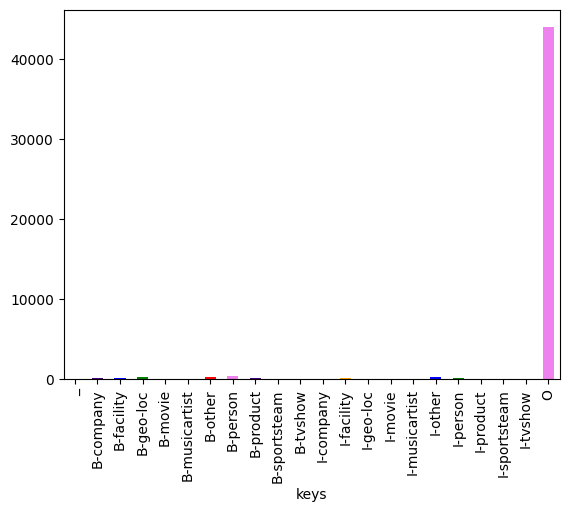

In [ ]:
colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']
counts = {}

for tag in schema:
  counts[tag] = 0
  for sample in train_samples:
    for label in sample:
      if label[1] == tag:
        counts[tag] += 1

counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)
# plt.show()

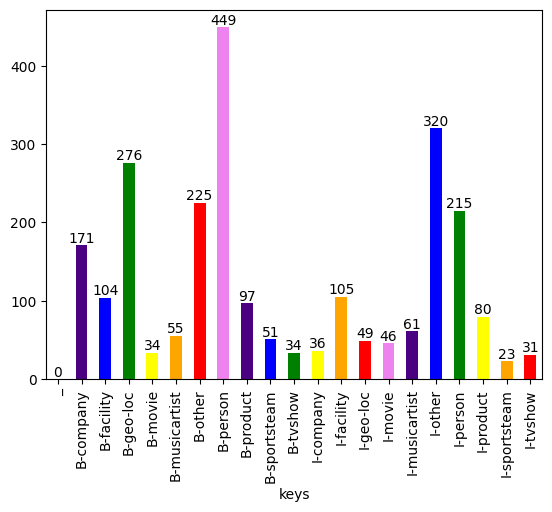

In [ ]:
counts.pop('O')
counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
ax = counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)
ax.bar_label(ax.containers[0])
plt.show()

In [13]:
from collections import namedtuple, defaultdict, Counter, OrderedDict

In [14]:
Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False):
    tag_count = defaultdict(int)
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if notypes:
                    line[1] = line[1][0]
                tag_count[line[1]] += 1
                #print line
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences, tag_count

In [15]:
sequences, tag_count = load_sequences(train_file, sep="\t")

In [16]:
len(sequences)

2394

In [17]:
tag_count

defaultdict(int,
            {'O': 44007,
             'B-geo-loc': 276,
             'B-facility': 104,
             'I-facility': 105,
             'B-movie': 34,
             'I-movie': 46,
             'B-company': 171,
             'B-product': 97,
             'B-person': 449,
             'B-other': 225,
             'I-other': 320,
             'B-sportsteam': 51,
             'I-sportsteam': 23,
             'I-product': 80,
             'I-company': 36,
             'I-person': 215,
             'I-geo-loc': 49,
             'B-tvshow': 34,
             'B-musicartist': 55,
             'I-musicartist': 61,
             'I-tvshow': 31})

In [18]:
df = pd.DataFrame(sum(sequences, []))

In [19]:
df.head()

,token,tag
0,@SammieLynnsMom,O
1,@tg10781,O
2,they,O
3,will,O
4,be,O


In [20]:
df.shape

(46469, 2)

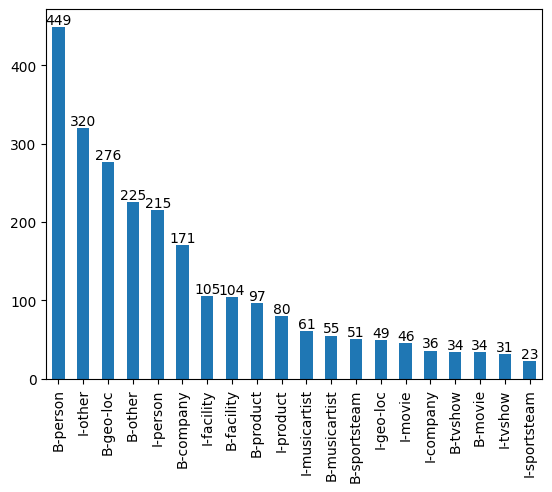

In [ ]:
ax = df[df.tag != "O"]["tag"].value_counts().plot(kind="bar")
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
def count_phrases(sequences, ptype="movie"):
    phrase_counts = defaultdict(int)
    check_tag = ptype
    for seq in sequences:
        phrase = ""
        for tag in seq:
            if not phrase and tag.tag == "B-%s" % check_tag:
                phrase = tag.token
                continue
            if tag.tag == "I-%s" % check_tag:
                phrase += " %s" % tag.token
                continue
            if phrase:
                phrase_counts[phrase] += 1
                phrase = ""
    return phrase_counts

def count_phrases_lengths(sequences):
    lengths = []
    for seq in sequences:
        phrase_len = 0
        for tag in seq:
            if tag.tag[0] == "B":
                if phrase_len == 0:
                    phrase_len += 1
                else:
                    lengths.append(phrase_len)
                    phrase_len = 1
                continue
            if tag.tag[0] == "I":
                phrase_len += 1
                continue
            if phrase_len:
                lengths.append(phrase_len)
                phrase_len = 0
        if phrase_len:
            lengths.append(phrase_len)
            phrase_len = 0
    return lengths

In [ ]:
lengths = count_phrases_lengths(sequences)

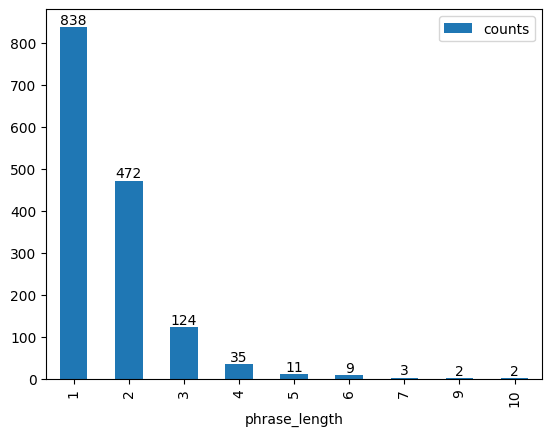

In [ ]:
ax = pd.DataFrame(sorted(Counter(lengths).items()), columns=["phrase_length", "counts"]).plot(x="phrase_length", y="counts", kind="bar")
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
df_t = df[df.tag != "O"]["tag"].value_counts().reset_index()
df_t[["Boundary", "Class"]] = df_t["index"].str.split("-", 1, expand=True)
df_t

,index,tag,Boundary,Class
0,B-person,449,B,person
1,I-other,320,I,other
2,B-geo-loc,276,B,geo-loc
3,B-other,225,B,other
4,I-person,215,I,person
5,B-company,171,B,company
6,I-facility,105,I,facility
7,B-facility,104,B,facility
8,B-product,97,B,product
9,I-product,80,I,product


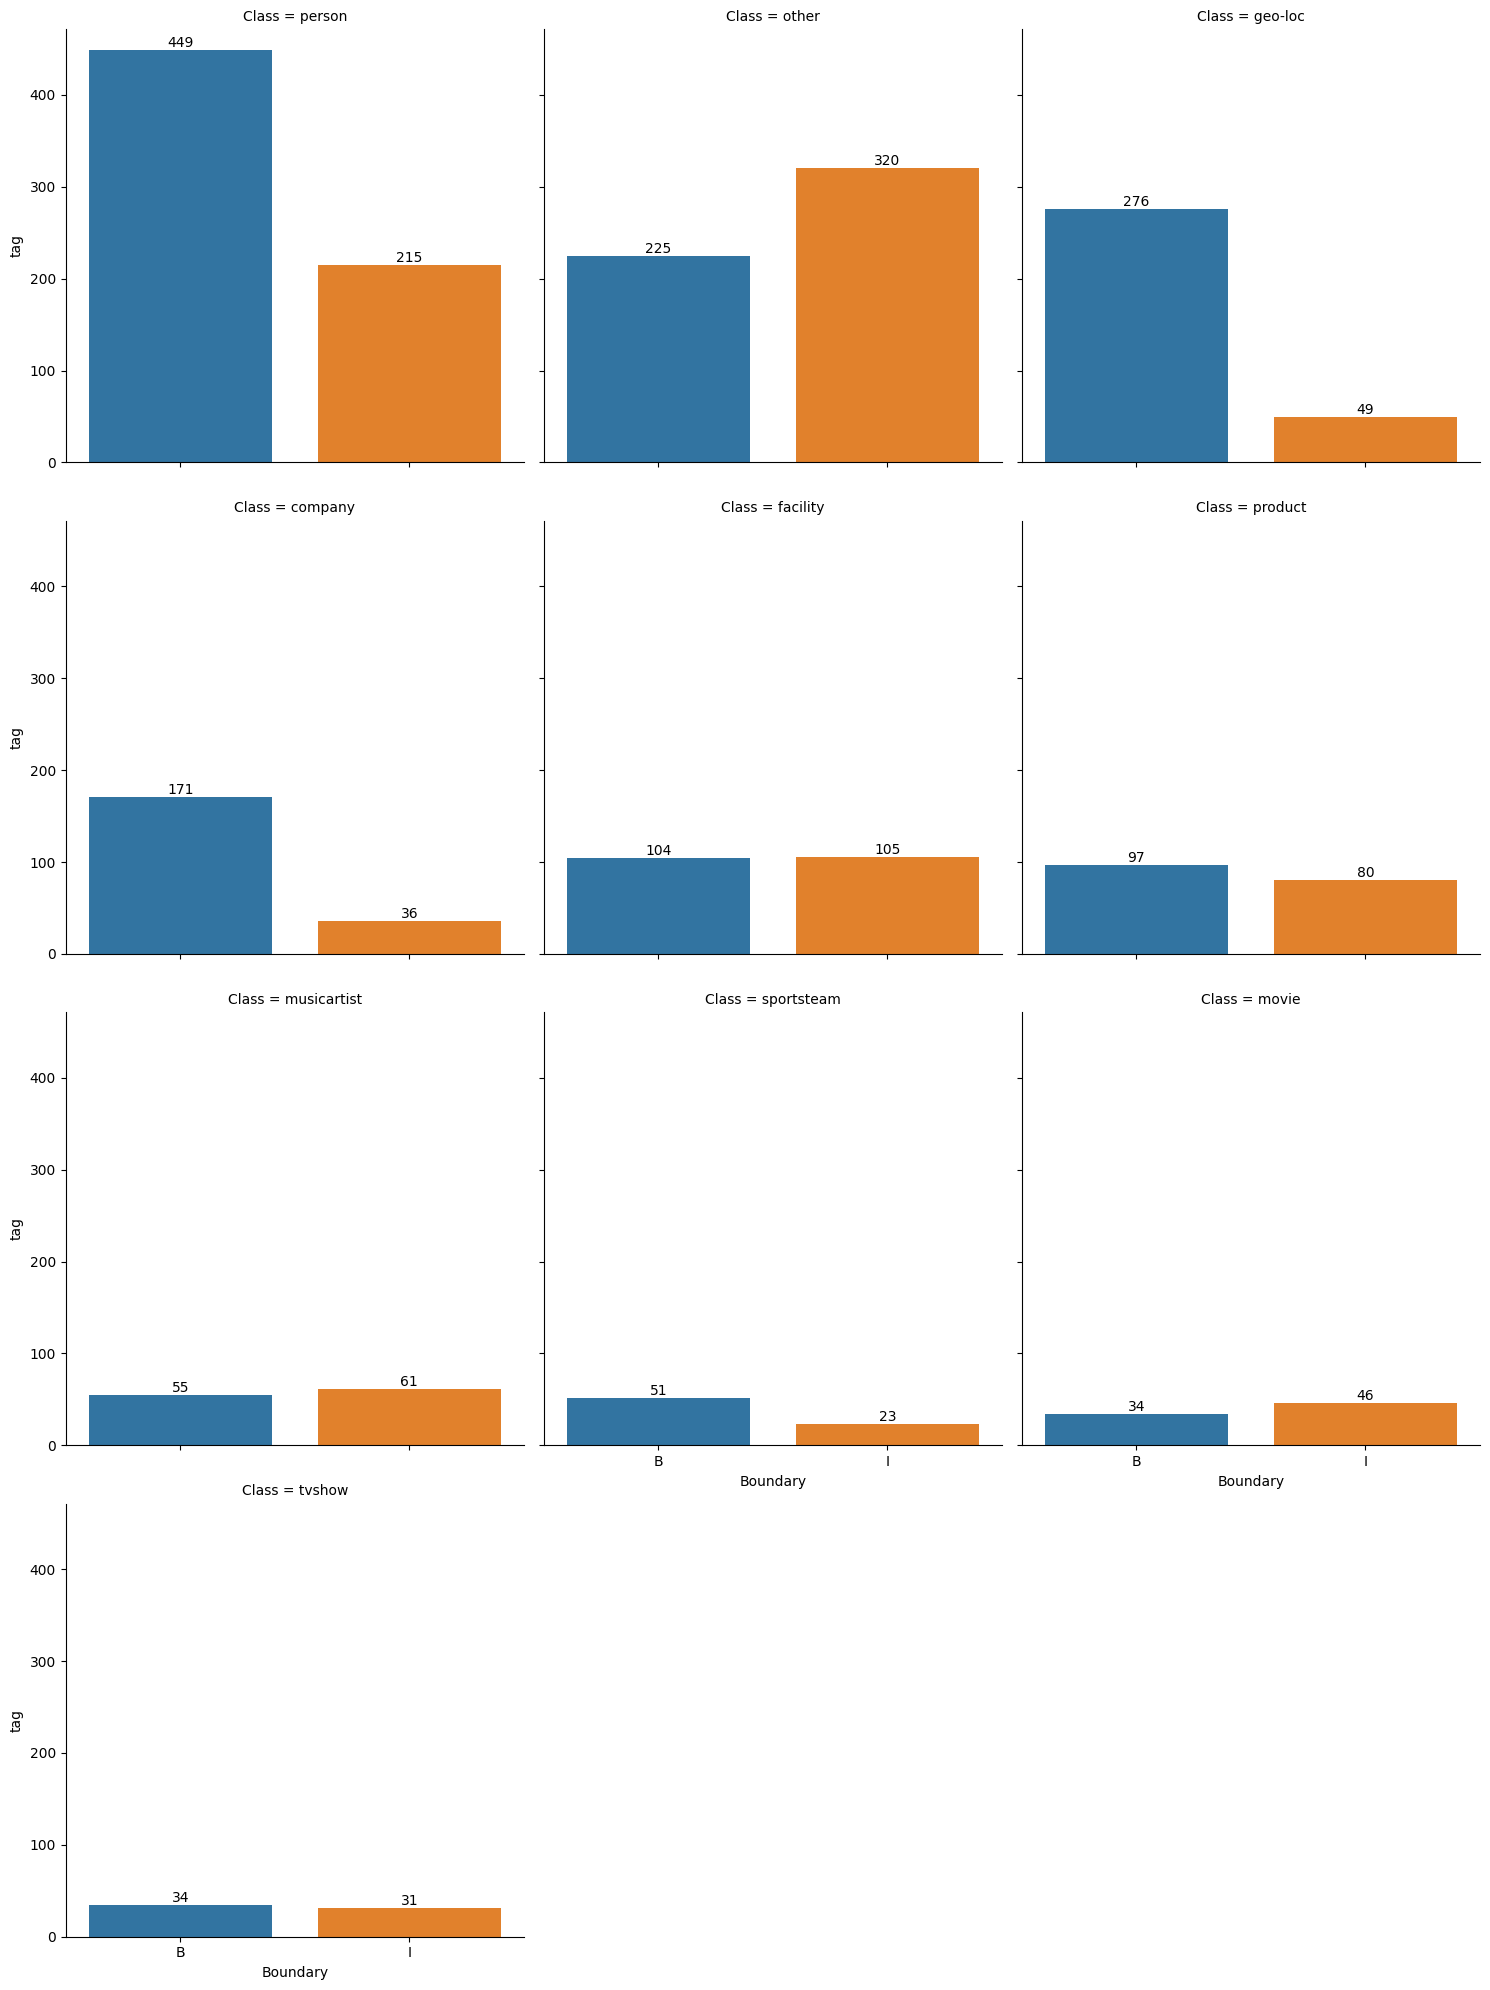

In [ ]:
grid = sns.catplot(x="Boundary", y="tag", col="Class", data=df_t, col_wrap=3, kind="bar")
for i in range(10):
  ax = grid.axes[i]
  ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
import regex as re

In [ ]:
URL_REGEX = re.compile(r'^http[s]?://')
assert URL_REGEX.match("http://Google.com") is not None
assert URL_REGEX.match("https://Google.com") is not None
assert URL_REGEX.match("abchttps://Google.com") is None

In [ ]:
REPEATED_CHAR_REGEX=re.compile(r'^[\.\,!\?"\':;_\-]{2,}$')
assert REPEATED_CHAR_REGEX.match("!") is None
assert REPEATED_CHAR_REGEX.match("!!") is not None
assert REPEATED_CHAR_REGEX.match("!?...!") is not None
assert REPEATED_CHAR_REGEX.match('".') is not None
assert REPEATED_CHAR_REGEX.match("aaaaa") is None
assert REPEATED_CHAR_REGEX.match('\".') is not None

In [ ]:
WORD_REGEX=re.compile(r'^([A-Za-z]+[\'\-\.]?)+$')
assert WORD_REGEX.match("ABC") is not None
assert WORD_REGEX.match("ABC-D") is not None
assert WORD_REGEX.match("ABC'D") is not None
assert WORD_REGEX.match("ABC.DFC.") is not None
assert WORD_REGEX.match("9-1") is None
assert WORD_REGEX.match("A.B.C") is not None

In [ ]:
PUNCT_REGEX=re.compile(r'^\p{P}$')
assert PUNCT_REGEX.match(".") is not None
assert PUNCT_REGEX.match("?") is not None
assert PUNCT_REGEX.match("!") is not None
assert PUNCT_REGEX.match("aa") is None
assert PUNCT_REGEX.match("a.") is None

In [ ]:
NUMBER_REGEX=re.compile(r'^(([0-9]*[.]?[0-9]+)|([0-9]+[,]?[0-9]+))$')
assert NUMBER_REGEX.match("123") is not None
assert NUMBER_REGEX.match("123,4") is not None
assert NUMBER_REGEX.match("12.5") is not None
assert NUMBER_REGEX.match(".5") is not None
assert NUMBER_REGEX.match("12-A") is None
assert NUMBER_REGEX.match(",55") is None
assert NUMBER_REGEX.match("5.5.55") is None

In [ ]:
def get_token_type(t):
    if len(t.token) > 1 and t.token[0] in ['\'', '\"', '(', '-']:
        return get_token_type(Tag(t.token[1:], t.tag))
    if PUNCT_REGEX.match(t.token):
        return "Puctuation"
    if len(t.token) > 1 and t.token[0] == "@":
        return "Mention"
    if len(t.token) > 1 and t.token[0] == "#":
        return "Hashtag"
    if len(t.token) > 1 and t.token[0] == "$":
        return "Money"
    if URL_REGEX.match(t.token):
        return "URL"
    if NUMBER_REGEX.match(t.token):
        return "Number"
    if WORD_REGEX.match(t.token):
        return "Word"
    if t.token.isalnum():
        return "Alphanumeric"
    if REPEATED_CHAR_REGEX.match(t.token):
        return "Repeatedchar"
    return "Other"

In [ ]:
pd.DataFrame(Counter(get_token_type(t) for seq in sequences for t in seq).most_common(), columns=["Type", "Counts"])

,Type,Counts
0,Word,36523
1,Puctuation,4848
2,Mention,1300
3,Other,1029
4,Repeatedchar,1010
5,Number,657
6,Hashtag,449
7,URL,448
8,Alphanumeric,185
9,Money,20


In [ ]:
other_tokens = filter(lambda x: get_token_type(x) == "Money", (t for seq in sequences for t in seq))

In [ ]:
token_counts = Counter(t.token for t in other_tokens).most_common()
for i, t in enumerate(token_counts):
  print(f"[{i}] {t}")

In [ ]:
TYPE_MAPPINGS=OrderedDict({
    "Other": "OOV",
    "Hashtag": "#Hashtag",
    "Mention": "@Mention",
    "Puctuation": ".",
    "Number": "1111",
    "Money": "$100",
    "URL": "http://URL.com",
    "Repeatedchar": "..."
})

def get_vocab(sequences, prepend_extras=True):
  excluded_types=set(TYPE_MAPPINGS.keys())
  vocab = defaultdict(int)
  for seq in sequences:
    for t in seq:
      t_type = get_token_type(t)
      if t_type not in excluded_types:
        vocab[t.token] += 1
  id2word = ["OOV"]
  if prepend_extras:
    id2word = ["<MASK>", "<BOS>", "<EOS>"] + list(TYPE_MAPPINGS.values())
  id2word.extend([t[0] for t in sorted(vocab.items(), key=lambda x: x[1], reverse=True)])
  print(len(id2word))
  word2id = OrderedDict({k:i for i,k in enumerate(id2word)})
  return id2word, word2id, vocab

In [ ]:
id2word, word2id, vocab = get_vocab(sequences)

8033


In [ ]:
assert len(id2word) == len(word2id)

In [ ]:
Counter(id2word).most_common(10)

[('<MASK>', 1),
 ('<BOS>', 1),
 ('<EOS>', 1),
 ('OOV', 1),
 ('#Hashtag', 1),
 ('@Mention', 1),
 ('.', 1),
 ('1111', 1),
 ('$100', 1),
 ('http://URL.com', 1)]

In [ ]:
with open("vocab.txt", "w+") as fp:
    for t in id2word:
        print(t, file=fp)
print("Done")

id2word, word2id, vocab = get_vocab(sequences, prepend_extras=False)
with open("vocab.no_extras.txt", "w+") as fp:
    for t in id2word:
        print(t, file=fp)
print("Done")


Done
8023
Done


In [ ]:
def phrases_per_seq(sequences):
    count_phrases = []
    count_phrase_types = defaultdict(list)
    for seq in sequences:
        current_phrase_count = 0
        phrase_type_count = defaultdict(int)
        for t in seq:
            if t.tag[0] in ("U", "B"):
                current_phrase_count += 1
                phrase_type_count[t.tag[2:]] += 1
        count_phrases.append(current_phrase_count)
        for k,v in phrase_type_count.items():
            count_phrase_types[k].append(v)
    return count_phrases, count_phrase_types

In [ ]:
count_phrases, count_phrase_types = phrases_per_seq(sequences)

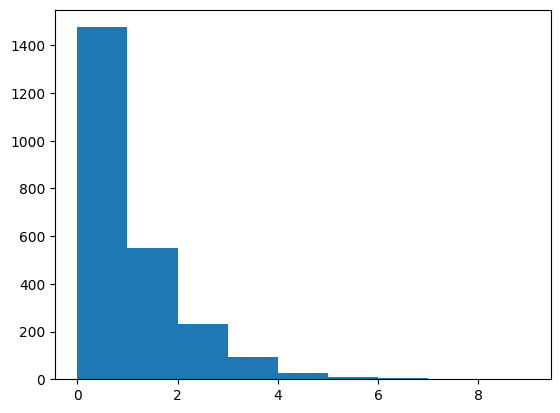

In [ ]:
plt.hist(count_phrases, bins=range(10))
# ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
len(count_phrases)

2394

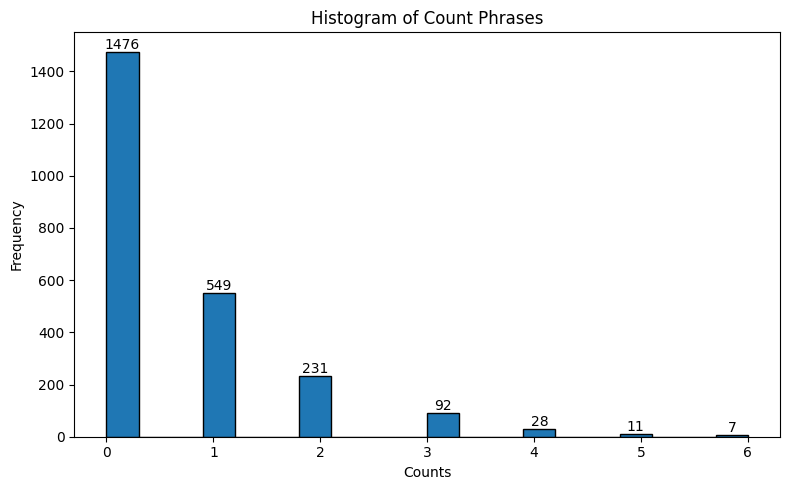

In [ ]:
plt.figure(figsize=(8, 5))

num_bins = 20  # Adjust the number of bins as needed

n, bins, patches = plt.hist(count_phrases, bins=num_bins, edgecolor='black')

# Add bar labels
for i in range(len(patches)):
    height = int(n[i])
    if height > 0:
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, height,
                 str(height), ha='center', va='bottom')

plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Count Phrases')

plt.tight_layout()
plt.show()


In [ ]:
Counter(sorted(count_phrases))

Counter({0: 1476, 1: 549, 2: 231, 3: 92, 4: 28, 5: 11, 6: 7})

In [ ]:
Counter(count_phrases)[0] * 100. / len(sequences)

61.65413533834587

In [ ]:
count_phrases.index(6)

445

In [ ]:
sequences[445]

[Tag(token='Yahoo', tag='B-company'),
 Tag(token=':', tag='O'),
 Tag(token='Jackie', tag='B-person'),
 Tag(token='joins', tag='O'),
 Tag(token='Twitter', tag='B-company'),
 Tag(token='50', tag='O'),
 Tag(token='years', tag='O'),
 Tag(token='after', tag='O'),
 Tag(token='JFK', tag='B-person'),
 Tag(token='campaign', tag='O'),
 Tag(token=':', tag='O'),
 Tag(token='Had', tag='O'),
 Tag(token='Twitter', tag='B-company'),
 Tag(token='been', tag='O'),
 Tag(token='an', tag='O'),
 Tag(token='option', tag='O'),
 Tag(token='in', tag='O'),
 Tag(token='1960', tag='O'),
 Tag(token=',', tag='O'),
 Tag(token='a', tag='O'),
 Tag(token='pregnant', tag='O'),
 Tag(token='Jacquelin', tag='B-person'),
 Tag(token='...', tag='O'),
 Tag(token='http://yhoo.it/9VAD4A', tag='O')]

In [ ]:
for k, v in count_phrase_types.items():
  print(k, Counter(v))

geo-loc Counter({1: 162, 2: 43, 4: 4, 3: 4})
facility Counter({1: 84, 2: 10})
movie Counter({1: 20, 3: 2, 2: 2, 4: 1})
company Counter({1: 134, 2: 14, 3: 3})
product Counter({1: 56, 2: 12, 3: 3, 4: 2})
person Counter({1: 269, 2: 54, 3: 17, 4: 4, 5: 1})
other Counter({1: 166, 2: 23, 3: 3, 4: 1})
sportsteam Counter({1: 33, 2: 9})
tvshow Counter({1: 32, 2: 1})
musicartist Counter({1: 35, 3: 4, 2: 4})


In [ ]:
def phrases_context_words(sequences, lowercase=False):
    context_words = defaultdict(lambda : defaultdict(int))
    global_word_counts = defaultdict(int)
    for seq in sequences:
        phrase_types = set()
        outside_word_counts = defaultdict(int)
        for t in seq:
            token, tag = t
            if lowercase:
                token = token.lower()
            if tag[0] in ("U", "B"):
                phrase_types.add(tag[2:])
            elif t.tag[0] == "O":
                outside_word_counts[token] += 1
        for k,v in outside_word_counts.items():
            global_word_counts[k] += 1
            for p in phrase_types:
                context_words[p][k] += v
    return context_words, global_word_counts

In [ ]:
context_words, global_word_counts = phrases_context_words(sequences, lowercase=True)

In [ ]:
context_words.keys()

dict_keys(['facility', 'geo-loc', 'movie', 'company', 'product', 'other', 'person', 'sportsteam', 'tvshow', 'musicartist'])

In [ ]:
def get_diff_type_occurence(w,context_words):
    n = 0
    for k, v in context_words.items():
        if w in v:
            n += 1
    return n

In [ ]:
TOPN = 10
context_sums = {k: (sum(v.values()) * 1.) for k, v in context_words.items()}
lobal_sum = len(context_words) * 1.
for k, v in context_words.items():
  print("Top %s tokens in category %s: " % (TOPN, k))
  for t in sorted(v.items(), key=lambda x: ((x[1] / context_sums[k]) * np.log10(global_sum / get_diff_type_occurence(x[0], context_words))), reverse=True)[:TOPN]:
    print("\t%s: %s" % t)

Top 10 tokens in category facility: 
	night: 10
	soyrizo: 2
	tamales: 2
	salsa: 2
	safety: 2
	self-defense: 2
	@paulwalk: 2
	view: 2
	saturday: 5
	where: 6
Top 10 tokens in category geo-loc: 
	party: 10
	follow: 6
	f: 3
	sony/bud: 3
	light: 3
	3d: 3
	http://bit.ly/cds8pd: 3
	forward: 3
	beautiful: 4
	etc: 4
Top 10 tokens in category movie: 
	movie: 5
	@glasgowfilm: 2
	applications: 2
	http://bit.ly/bhulum: 2
	5:00: 2
	7:00: 2
	8:45: 2
	movies: 3
	really: 5
	:p: 2
Top 10 tokens in category company: 
	drama: 7
	@liltwist: 5
	edition: 7
	videos: 9
	meltdowns: 5
	epic: 6
	cryin: 3
	http://bit.ly/cuy0yt: 3
	usually: 4
	email: 4
Top 10 tokens in category product: 
	mascara: 2
	tank: 2
	record: 2
	refresh: 2
	hand: 2
	monday: 3
	want: 5
	@corsairartisan: 2
	arrived: 2
	ships: 2
Top 10 tokens in category other: 
	stressful: 3
	style: 3
	driving: 7
	nap: 3
	thedeandreway: 3
	@souljaboy: 3
	list: 4
	nov: 4
	monday: 4
	away: 4
Top 10 tokens in category person: 
	...": 14
	took: 17
	part: 14
	wake

In [ ]:
phrase_type_key="tvshow"
df_t = pd.DataFrame(context_words[phrase_type_key].items(), columns=["token", "count"])
df_t["normed_score"] = df_t.apply(lambda x: (x["count"] /context_sums[phrase_type_key]), axis=1)
df_t["normed_global_score"] = df_t.apply(lambda x: np.log10(global_sum/get_diff_type_occurence(x[0], context_words)), axis=1)
df_t["tf_idf"] = df_t["normed_score"]*df_t["normed_global_score"]
df_t.sort_values("tf_idf", ascending=False).head(10)

,token,count,normed_score,normed_global_score,tf_idf
163,loop,2,0.003503,1.00000,0.003503
160,@k8_walsh,2,0.003503,1.00000,0.003503
82,http://ht.ly/2g4ns,2,0.003503,0.69897,0.002448
28,stupid,2,0.003503,0.69897,0.002448
252,premiere,2,0.003503,0.69897,0.002448
76,costa,2,0.003503,0.69897,0.002448
77,rican,2,0.003503,0.69897,0.002448
176,episodes,2,0.003503,0.69897,0.002448
84,@fuseboxradio,2,0.003503,0.69897,0.002448
85,@planetill,2,0.003503,0.69897,0.002448


In [ ]:
phrase_type_key="person"
df_t = pd.DataFrame(context_words[phrase_type_key].items(), columns=["token", "count"])
df_t["normed_score"] = df_t.apply(lambda x: (x["count"] /context_sums[phrase_type_key]), axis=1)
df_t["normed_global_score"] = df_t.apply(lambda x: np.log10(global_sum/get_diff_type_occurence(x[0], context_words)), axis=1)
df_t["tf_idf"] = df_t["normed_score"]*df_t["normed_global_score"]
df_t.sort_values("tf_idf", ascending=False).head(10)

,token,count,normed_score,normed_global_score,tf_idf
165,"...""",14,0.002070,0.698970,0.001447
155,took,17,0.002514,0.522879,0.001314
167,part,14,0.002070,0.522879,0.001082
321,wake,7,0.001035,1.000000,0.001035
319,concert,10,0.001479,0.698970,0.001034
318,trampled,6,0.000887,1.000000,0.000887
320,yoiu,6,0.000887,1.000000,0.000887
166,got,24,0.003549,0.221849,0.000787
382,test,10,0.001479,0.522879,0.000773
169,try,17,0.002514,0.301030,0.000757


In [ ]:
phrase_type_key="geo-loc"
df_t = pd.DataFrame(context_words[phrase_type_key].items(), columns=["token", "count"])
df_t["normed_score"] = df_t.apply(lambda x: (x["count"] /context_sums[phrase_type_key]), axis=1)
df_t["normed_global_score"] = df_t.apply(lambda x: np.log10(global_sum/get_diff_type_occurence(x[0], context_words)), axis=1)
df_t["tf_idf"] = df_t["normed_score"]*df_t["normed_global_score"]
df_t.sort_values("tf_idf", ascending=False).head(10)

,token,count,normed_score,normed_global_score,tf_idf
137,party,10,0.002571,0.397940,0.001023
940,follow,6,0.001542,0.522879,0.000806
730,http://bit.ly/cds8pd,3,0.000771,1.000000,0.000771
341,f,3,0.000771,1.000000,0.000771
1046,forward,3,0.000771,1.000000,0.000771
727,3d,3,0.000771,1.000000,0.000771
725,sony/bud,3,0.000771,1.000000,0.000771
726,light,3,0.000771,1.000000,0.000771
37,beautiful,4,0.001028,0.698970,0.000719
200,etc,4,0.001028,0.698970,0.000719


### Questionnaire

What other ner data annotation formats are available and how are they different
Ans: In addition to CoNLL, the other NER data anootation formats are - JSON, XML, CSV, BIO/BIOES, PASCAL VOC, COCO

Why do we need tokenization of the data in our case
Tokenization is a fundamental step in NLP that transforms raw text data into a structured and meaningful representation that can be fed into machine learning models for various tasks, such as classification, translation, sentiment analysis, and more.

What other models can you use for this task
The other models are: Rule-based tokenization, NLTK, SpaCy tokenizer, OpenNLP tokenizer, Transformers library tokenizer, Byte-Pair Encoding (BPE), SentencePiece, Unigram Language Model.

Did early stopping have any effect on the training and results.
Yes

How does the BERT model expect a pair of sentences to be processed?
BERT is designed to understand the context of words in a sentence bidirectionally, which means it considers both the left and right context of each word.

Why choose Attention based models over Recurrent based ones?
Attention-based models have gained popularity due to their ability to handle long-range dependencies, parallelize well, provide interpretability, and facilitate transfer learning.

Differentiate BERT and simple transformers
BERT is a specific transformer-based language model architecture that is pre-trained on a large corpus of text and fine-tuned on specific tasks. On the other hand, Simple Transformers is a Python library that provides a user-friendly interface to work with transformer-based models like BERT and perform various NLP tasks without dealing with the low-level implementation details of the underlying Transformers library. Simple Transformers makes it easier to use and leverage transformer models for NLP applications.
